# Data Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import holidays
import itertools

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from plotnine import *





from pathlib import Path

In [111]:
# BASE_DIR = Path(__name__).resolve().parent.parent
FILES_DIR = '../files/'
bidding_df = pd.read_csv(FILES_DIR + 'bidding_results.csv')
log_df = pd.read_csv(FILES_DIR + 'log_csv.csv')

In [4]:
bidding = bidding_df.copy()
log = log_df.copy()

In [5]:
# data columns, rows
print('Features:', log.shape[1], ';', 'Entries:', log.shape[0])
print('Features:', bidding.shape[1], ';', 'Entries:', bidding.shape[0])

Features: 11 ; Entries: 5659541
Features: 14 ; Entries: 1337088


In [6]:
# column describe 
def descriptive_info(log):
    number_of_cells = log.count(axis=0, level=None, numeric_only=False)
    print('Total number of cells the datafile has: \n' + str(number_of_cells))
    print('\n')
    print('Printing descriptive statistics...\n\n', log.describe())

descriptive_info(log)

Total number of cells the datafile has: 
Unnamed: 0         5659541
uid                5473228
action_type        5659541
category1          5659541
category2          5659541
category3          4879535
collect_time       5659541
geoip_city_name    5242509
useragent_os       5659541
viewrate           5657112
viewtime           5659541
dtype: int64


Printing descriptive statistics...

          Unnamed: 0      viewrate      viewtime
count  5.659541e+06  5.657112e+06  5.659541e+06
mean   2.829770e+06  7.677686e+01  5.126022e+04
std    1.633769e+06  4.221447e+01  5.810345e+05
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.414885e+06  1.000000e+02  8.940000e+02
50%    2.829770e+06  1.000000e+02  1.010400e+04
75%    4.244655e+06  1.000000e+02  4.800500e+04
max    5.659540e+06  1.000000e+02  8.636989e+07


In [7]:
# column describe 
def descriptive_info(bidding):
    number_of_cells = bidding.count(axis=0, level=None, numeric_only=False)
    print('Total number of cells the datafile has: \n' + str(number_of_cells))
    print('\n')
    print('Printing descriptive statistics...\n\n', bidding.describe())

descriptive_info(bidding)

Total number of cells the datafile has: 
index              1337088
Impression         1337088
Click              1337088
Cost               1337088
Sum of AD rank     1337078
Bid                1337088
Price(PC)          1337088
Price(Mobile)      1337088
Delivery Fee       1337088
Category Name 1    1337088
Category Name 2    1337088
Category Name 3    1331221
Category Name 4     930132
date               1337088
dtype: int64


Printing descriptive statistics...

               index    Impression         Click          Cost  Sum of AD rank  \
count  1.337088e+06  1.337088e+06  1.337088e+06  1.337088e+06    1.337078e+06   
mean   5.167098e+06  4.412753e+01  7.189467e-01  1.800053e+02    1.138271e+01   
std    2.655813e+06  3.434510e+02  3.423456e+00  1.772706e+03    1.323231e+01   
min    2.578600e+04  0.000000e+00  0.000000e+00  0.000000e+00    1.000000e+00   
25%    3.300168e+06  3.000000e+00  0.000000e+00  0.000000e+00    3.706897e+00   
50%    4.637081e+06  1.000000e+01  0.000000

In [8]:
# 날짜 데이터 데이트타임으로 바꾸기
def _trans_date_time(log):
    log.index = pd.to_datetime(log['collect_time'], infer_datetime_format=True)
    log.drop('collect_time', axis=1, inplace=True)
    return log

_trans_date_time(log)

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime
collect_time,,,,,,,,,,
2022-12-29 17:29:02,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,Seongnam-si,Windows,100.0,80033
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0
2022-12-29 17:11:30,2,r8DXy2OtSl8AAojG,View,패브릭,커튼·부자재,암막커튼,Seoul,iOS,100.0,947
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0
2022-12-29 18:45:05,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,Jongno-gu,Mac OS X,100.0,1238
...,...,...,...,...,...,...,...,...,...,...
2022-12-28 20:01:30,5659536,PUpxWWMWdcIACR2B,View,주방용품,칼·커팅기구,채칼·다지기·강판,Seoul,Android,100.0,13893
2022-12-28 14:30:09,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,Jinju,Windows,0.0,0
2022-12-29 12:45:13,5659538,diRXdmN49dUABrVo,View,가구,테이블·식탁·책상,식탁,Gunpo,Android,100.0,47217


In [9]:
# bidding 날짜 datetime으로 만들기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

_trans_date_time(bidding)

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [10]:
log_imp_cor = ['action_type', 'category1', 'geoip_city_name', 'viewrate', 'viewtime']

In [11]:
bid_imp_cor = ['Impression',
'Click',
'Cost',
'Sum of AD rank'
'Bid',
'Price(PC)',
'Delivery Fee',
'Category Name 1',
'CTC',
'CTR',
'CPM']

# log data

## 결측치 처리

In [12]:
# null값 퍼센트로 보기
(log.isnull().sum()/ log.shape[0]).sort_values(ascending=False)

category3          0.137821
geoip_city_name    0.073687
uid                0.032920
viewrate           0.000429
Unnamed: 0         0.000000
action_type        0.000000
category1          0.000000
category2          0.000000
useragent_os       0.000000
viewtime           0.000000
dtype: float64

In [13]:
# null값 보기
log.isnull().sum().sort_values(ascending=False)

category3          780006
geoip_city_name    417032
uid                186313
viewrate             2429
Unnamed: 0              0
action_type             0
category1               0
category2               0
useragent_os            0
viewtime                0
dtype: int64

In [14]:
# 서울과 경기도는 시, 구와 중복 데이터이기 때문에 drop한다
log_null_ts = log.copy()
drop_city = log_null_ts[log_null_ts['geoip_city_name'] != 'Seoul']
drop_city = drop_city[drop_city['geoip_city_name'] != 'Gyeonggi-do']

drop_city.isnull().sum().sort_values(ascending=False)

category3          643126
geoip_city_name    417032
uid                132162
viewrate             1722
Unnamed: 0              0
action_type             0
category1               0
category2               0
useragent_os            0
viewtime                0
dtype: int64

In [15]:
# null값들을 un_** 으로 채워서 확인해보기
log_drop_null = drop_city
log_drop_null['geoip_city_name'].fillna('un_city_name', inplace = True)
log_drop_null['category3'].fillna('un_category', inplace = True)
log_drop_null['uid'].fillna('un_name', inplace = True)
log_drop_null.dropna(axis = 0, inplace = True)
print(log_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

Unnamed: 0         0
uid                0
action_type        0
category1          0
category2          0
category3          0
geoip_city_name    0
useragent_os       0
viewrate           0
viewtime           0
dtype: int64


In [16]:
# 비로그인만의 큰 특징은 없다.
# 비로그인으로 보다가 자기가 사고싶은 물건이 있으면 다시 로그인 하는 경우가 일반적이니 큰 특징을 보이지 않는것이 어떻게 보면 당연
# 비로그인 인데 act중에 Basket이 있는게 조금 웃기긴함 ㅋㅋ
un_name = log_drop_null[log_drop_null['uid'] == 'un_name']
for cor in log_imp_cor:
    log_drop_cor = log_drop_null[cor].value_counts(normalize=True)
    un_name_cor = un_name[cor].value_counts(normalize=True)
    
    print('기존 로그')
    print(cor)
    print(log_drop_cor)
    print('\n')
    print('비로그인')
    print(cor)
    print(un_name_cor)
    print('\n')    
    print('-' * 30)
    print('\n') 

기존 로그
action_type
View         0.862716
Highlight    0.082997
Basket       0.031032
Copy         0.018725
SINF         0.004530
Name: action_type, dtype: float64


비로그인
action_type
View         0.951287
SINF         0.048236
Highlight    0.000416
Copy         0.000053
Basket       0.000008
Name: action_type, dtype: float64


------------------------------


기존 로그
category1
가구        3.566225e-01
패브릭       1.164648e-01
주방용품      9.764721e-02
가전·디지털    9.194872e-02
데코·식물     7.767359e-02
              ...     
업테리어      2.140842e-07
돗투돗       2.140842e-07
오딕        2.140842e-07
아우어데이즈    2.140842e-07
톰의다락방     2.140842e-07
Name: category1, Length: 3140, dtype: float64


비로그인
category1
가구         0.297273
가전·디지털     0.157606
패브릭        0.089123
데코·식물      0.087344
주방용품       0.072630
수납·정리      0.072191
생활용품       0.041704
노하우        0.040380
유아·아동      0.038427
공구·DIY     0.025976
조명         0.020239
캠핑용품       0.017151
반려동물       0.015660
생필품        0.011588
식품         0.005124
실내운동    

In [17]:
# 노하우가 30% 라는것이 특징이다
# 노하우라는것을 카테고리 세분화가 쉽지 않아서 null 값이였나보다
# 이 값은 drop하면 안될것같다
un_cat = log_drop_null[log_drop_null['category3'] == 'un_category']
un_cat['category1'].value_counts(normalize=True)


노하우         0.308309
가구          0.186264
조명          0.103384
패브릭         0.083743
공구·DIY      0.061985
              ...   
리넥          0.000002
엘데팩토리       0.000002
ışık        0.000002
Ноу-хау     0.000002
스트랩월드       0.000002
Name: category1, Length: 2480, dtype: float64

In [18]:
un_city_name = log_drop_null[log_drop_null['geoip_city_name'] == 'un_city_name']
un_city_name['category1'].value_counts(normalize=True)

가구        0.367315
패브릭       0.107045
가전·디지털    0.098188
주방용품      0.087922
데코·식물     0.072042
            ...   
리빙앤트리     0.000002
플라팜       0.000002
코아스       0.000002
生活用品      0.000002
아프로캣      0.000002
Name: category1, Length: 780, dtype: float64

## view columns 특징

In [19]:
"""

뷰레이트를 제로와 제로가 아닌값들의 특징을본다
뷰레이트가 제로가 아니면 모든 act 가 view 라는 특징을 보인다
뷰레이트는 마우스 스크롤을 넘기는 행동의 컬럼 여기서 다른 act가 포착이 되면
뷰레이트는 0 가되면서 act가 변경되는 시스템인것같다
핵심은 row 하나하나가 회원 한명한명이 아니라 회원 1명이라도 여러개의 row를 찍을수 있다는거다

"""
log_view_zero = log_drop_null[log_drop_null['viewrate'] == 0]
log_view_nonzero = log_drop_null[log_drop_null['viewrate'] > 0]


print('전체 로그')
print(log_drop_null['action_type'].value_counts(normalize=True, ascending=False))
print('\n')
print('viewrate non_zero')
print(log_view_nonzero['action_type'].value_counts(normalize=True, ascending=False))
print('\n')
print('viewrate zero')
print(log_view_zero['action_type'].value_counts(normalize=True, ascending=False))
print('-' * 30)
print('\n', '\n')
print('전체 로그')
print(log_drop_null['action_type'].value_counts(ascending=False))
print('\n')
print('viewrate non_zero')
print(log_view_nonzero['action_type'].value_counts(ascending=False))
print('\n')
print('viewrate zero')
print(log_view_zero['action_type'].value_counts(ascending=False))

전체 로그
View         0.862716
Highlight    0.082997
Basket       0.031032
Copy         0.018725
SINF         0.004530
Name: action_type, dtype: float64


viewrate non_zero
View    1.0
Name: action_type, dtype: float64


viewrate zero
View         0.395213
Highlight    0.365630
Basket       0.136709
Copy         0.082490
SINF         0.019957
Name: action_type, dtype: float64
------------------------------

 

전체 로그
View         4029798
Highlight     387682
Basket        144954
Copy           87465
SINF           21161
Name: action_type, dtype: int64


viewrate non_zero
View    3610749
Name: action_type, dtype: int64


viewrate zero
View         419049
Highlight    387682
Basket       144954
Copy          87465
SINF          21161
Name: action_type, dtype: int64


In [20]:
# 전체 act에서 뷰가 아닌 act를 하는 확률은 13%
# 회사 입장에서는 이 부분을 끌어올리는게 중요해 보인다
act_not_view = log_view_zero.loc[log_view_zero['action_type'] != 'View']
print((act_not_view.shape[0] / log_drop_null.shape[0]) * 100)

13.728404259418634


In [21]:
"""왜 전체 데이터가 아닌 act 뷰인 데이터의 cat1 top10을 봤냐면
왜 보기만 하고 다른 act를 안하는 cat가 있을까 하고 특징을 보고싶었지만 큰 특징은 없는것같다
또 뷰타임의 길이가 궁금했다"""


cat1_nonzero = log_view_nonzero.category1.value_counts()
cat1_nonzero = cat1_nonzero.reset_index()
cat1_nonzero[:10]

,index,category1
0,가구,1316290
1,패브릭,419280
2,주방용품,363764
3,가전·디지털,293668
4,데코·식물,282066
5,수납·정리,169644
6,노하우,141723
7,생활용품,141625
8,조명,105558
9,공구·DIY,70183


In [22]:
cat_top10 = ['가구', '패브릭', '주방용품', '가전·디지털', '데코·식물', '수납·정리', '노하우', '생활용품', '조명', '공구·DIY']

In [23]:
"""
딱히 top10에서는 큰 특징이 없는것 같다
cat적으로 접근하면...시간이 너무 걸릴것같다는 느낌이 든다

"""

for cat in cat_top10:
    cat_time_mean = log_view_nonzero.loc[log_view_nonzero['category1'] == cat, 'viewtime'].mean()
    print(cat)
    print(cat_time_mean * 1/10 / 60 / 60)
    print('\n')

가구
1.8387246698000526


패브릭
1.8797328357872756


주방용품
1.6563440160836878


가전·디지털
2.063557739805949


데코·식물
1.5430962996643025


수납·정리
1.813545652628118


노하우
2.797275064738962


생활용품
1.983964468765323


조명
1.7640120515630167


공구·DIY
2.0067124188826986




In [24]:
"""
서울과 경기도를 지우고 보니 의외로 대구가 1등으로 나온다
우리나라 평균 인구수를 생각해보면 의외로 큰 특징일수도?
"""
log_drop_null['geoip_city_name'].value_counts().reset_index()[:11]

,index,geoip_city_name
0,un_city_name,416882
1,Daegu,238133
2,Incheon,197041
3,Busan,193093
4,Seongnam-si,176448
5,Gangnam-gu,132609
6,Ulsan,131392
7,Suwon,124389
8,Daejeon,122716
9,Gwangju,117213


In [25]:
city_top10 = ['Daegu', 'Incheon', 'Busan', 'Seongnam-si', 'Gangnam-gu', 'Ulsan', 'Suwon', 'Daejeon', 'Gwangju', 'Yongin-si']

In [26]:
"""
평균 뷰타임이 부산이 1등이지만 엄청나게 큰 특징으로 해석하기는 힘들것같다
top10은 역시 큰 특징을 찾기 어려운것같다

"""

for city in city_top10:
    city_time_mean = log_view_nonzero.loc[log_view_nonzero['geoip_city_name'] == city, 'viewtime'].mean()
    print(city)
    print(city_time_mean * 1/10 / 60 / 60)
    print('\n')

Daegu
1.5630535528000136


Incheon
1.9212392675199483


Busan
2.257472111619586


Seongnam-si
1.518865595054563


Gangnam-gu
1.6538277620153181


Ulsan
1.1182482833690581


Suwon
1.9081207460933483


Daejeon
1.8152402561958716


Gwangju
1.8829091919825192


Yongin-si
1.89855546401676




In [27]:
useragent_os = ['Windows', 'Mac OS X', 'iOS', 'Android']

In [28]:
"""
보통 가구나 이런거 살때 컴퓨터로 꼼꼼하게 볼줄알았는데
모바일 쇼핑으로 많이 보는것같다
거기다가 mac, IOS 비율이 많은것같아서
젊은 사람이나 여성의 비율이 많을수도있다는 가설을 세워보자

근데 신혼부부가 주요 고객층일수도있다는 저번 가설을 대입해 보면
신혼부부 안에서 여성이 주로 소비를 하니 그럴수도있나?

그냥 가설정도로만 생각해보자

핵심은 window가 생각보다 적어서 의외다?

"""

for os in useragent_os:
    useragent_os_mean = log_view_nonzero.loc[log_view_nonzero['useragent_os'] == os, 'viewtime'].mean()
    print(os)
    print(useragent_os_mean * 1/10 / 60 / 60)
    print('\n')

Windows
1.6491375793164949


Mac OS X
2.1132430596207805


iOS
2.423825525959988


Android
2.0341504593040134




**결론**
 - view가 아닌 다른 act을 행동하는 비율 13%
 - viewtime 평균은 윈도우가 낮은것도 재미있는 점
 - 핵심은 viewrate이라는 column이 페이지를 스크롤 하는것이고 act하게되면 viewrate은 0가되면서 다른 act 생긴다
 - 즉, log데이터는 row 수만큼 회원이 한것이 아니라 한명이 여러개의 row를 만들수 있다

## category 특징

In [29]:
act_val = act_not_view['action_type'].unique()

In [30]:
for act in act_val:
    act_cat1 = log_view_zero.loc[log_view_zero['action_type'] == act, 'category1'].value_counts(normalize=True)
    print(act)
    print(act_cat1)
    print('\n')

Basket
가구                         0.277309
주방용품                       0.166011
패브릭                        0.150813
수납·정리                      0.089146
데코·식물                      0.087179
생활용품                       0.081536
가전·디지털                     0.051968
조명                         0.027574
공구·DIY                     0.020648
생필품                        0.014280
반려동물                       0.008817
식품                         0.007071
유아·아동                      0.006485
캠핑용품                       0.005381
실내운동                       0.002297
furniture                  0.000648
kitchen utensils           0.000648
인테리어시공                     0.000600
렌탈                         0.000345
장식 소품                      0.000297
厨房用具                       0.000152
装饰 植物                      0.000103
Decor Plant                0.000097
fabric                     0.000083
Storage, organization      0.000062
家电 数码                      0.000055
伴侶動物                       0.000048
存储、组织                

In [31]:
for city in city_top10:
    city_cat1 = log_drop_null.loc[log_drop_null['geoip_city_name'] == city, 'category1'].value_counts(normalize=True)
    print(city)
    print(city_cat1)
    print('\n')

Daegu
가구         0.352828
패브릭        0.132636
가전·디지털     0.111110
주방용품       0.098819
데코·식물      0.070595
             ...   
아보드        0.000004
살림의기술      0.000004
구디푸디       0.000004
HICKIES    0.000004
리빙힙        0.000004
Name: category1, Length: 358, dtype: float64


Incheon
가구           0.375835
패브릭          0.121284
주방용품         0.088048
가전·디지털       0.086535
데코·식물        0.077771
               ...   
mellbrown    0.000005
보노하우스        0.000005
아씨방가구        0.000005
테이스티드        0.000005
에이스침대        0.000005
Name: category1, Length: 525, dtype: float64


Busan
가구         0.362670
패브릭        0.117632
주방용품       0.098766
가전·디지털     0.094012
데코·식물      0.070246
             ...   
쁘띠메종       0.000005
몽목         0.000005
모던탑21      0.000005
아빠가만든공간    0.000005
필플랜트       0.000005
Name: category1, Length: 458, dtype: float64


Seongnam-si
가구        0.338117
주방용품      0.113841
패브릭       0.109783
데코·식물     0.092985
가전·디지털    0.085192
            ...   
이즈리빙      0.000006
큰바다가구점    0.

**결론**
 - cat 별 큰 특징은 찾기가 쉽지않다

# bidding data

## 결측치처리

In [32]:
bidding

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [33]:
"""
CTR, CPC, CPM 컬럼을 추가한다
rank는 round로 정수화 시켜서 본다
1.xxxxx나 1등이나 큰 차이는 없다
"""

# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
# Sum of AD rank = 반올림
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Cost"]/1000)
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)

In [34]:
"""
CPC는 클리이나 코스트의 0 값이 있다면 null 나올수있기 때문에 절대 drop하면 안된다
"""
# null값 퍼센트로 보기
(bidding.isnull().sum()/ bidding.shape[0]).sort_values(ascending=False)

CPC                0.753309
Category Name 4    0.304360
Category Name 3    0.004388
Sum of AD rank     0.000007
index              0.000000
Impression         0.000000
Click              0.000000
Cost               0.000000
Bid                0.000000
Price(PC)          0.000000
Price(Mobile)      0.000000
Delivery Fee       0.000000
Category Name 1    0.000000
Category Name 2    0.000000
CTR                0.000000
CPM                0.000000
dtype: float64

In [35]:
# null값 보기
bidding.isnull().sum().sort_values(ascending=False)

CPC                1007240
Category Name 4     406956
Category Name 3       5867
Sum of AD rank          10
index                    0
Impression               0
Click                    0
Cost                     0
Bid                      0
Price(PC)                0
Price(Mobile)            0
Delivery Fee             0
Category Name 1          0
Category Name 2          0
CTR                      0
CPM                      0
dtype: int64

In [36]:
"""
click 변수는 중요하다고 판단해서 컬럼으로 넣고 한번보자 0과 0이 아닌값들
CPC의 null값은 0으로 채워준다
cat4도 30%나 있기 때문에 drop하지 말고 다른이름으로 채워준다

"""

bidding_drop_null = bidding.copy()
bidding_drop_null["click_zero"] = (bidding_drop_null["Click"] == 0)
bidding_drop_null["click_non_zero"] = (bidding_drop_null["Click"] != 0)
bidding_drop_null['Category Name 4'].fillna('null_cat4', inplace = True)
bidding_drop_null['CPC'].fillna(0, inplace = True)
bidding_drop_null.dropna(axis = 0, inplace = True)
print(bidding_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

index              0
Impression         0
click_zero         0
CPM                0
CPC                0
CTR                0
Category Name 4    0
Category Name 3    0
Category Name 2    0
Category Name 1    0
Delivery Fee       0
Price(Mobile)      0
Price(PC)          0
Bid                0
Sum of AD rank     0
Cost               0
Click              0
click_non_zero     0
dtype: int64


In [37]:
"""
cat4에 있는 null값들의 큰 특징을 찾기 어렵다

"""

bid_imp_cor = ['Impression',
'Click',
'Cost',
'Sum of AD rank',
'Bid',
'Price(PC)',
'Delivery Fee',
'CPC',
'CTR',
'CPM']

# null_cat4 = bidding_drop_null[bidding_drop_null['Category Name 4'] == 'null_cat4']
# null_cat4



null_cat4 = bidding_drop_null[bidding_drop_null['Category Name 4'] == 'null_cat4']
for cor in bid_imp_cor:
    bid_null = bidding_drop_null[cor].value_counts(normalize=True)
    null_cat4_cor = null_cat4[cor].value_counts(normalize=True)
    
    print('기존 bid')
    print(cor)
    print(bid_null)
    print('\n')
    print('cat4_null')
    print(cor)
    print(null_cat4_cor)
    print('\n')    
    print('-' * 30)
    print('\n') 


기존 bid
Impression
1       1.150118e-01
2       8.373203e-02
3       6.515947e-02
4       5.281807e-02
5       4.448957e-02
            ...     
2211    7.511957e-07
3981    7.511957e-07
2767    7.511957e-07
1163    7.511957e-07
1590    7.511957e-07
Name: Impression, Length: 2732, dtype: float64


cat4_null
Impression
1        0.121974
2        0.088300
3        0.067771
4        0.054131
5        0.045965
           ...   
1698     0.000002
5559     0.000002
16107    0.000002
7786     0.000002
990      0.000002
Name: Impression, Length: 1607, dtype: float64


------------------------------


기존 bid
Click
0      7.524262e-01
1      1.354586e-01
2      4.597994e-02
3      2.153753e-02
4      1.211003e-02
           ...     
195    7.511957e-07
240    7.511957e-07
257    7.511957e-07
177    7.511957e-07
455    7.511957e-07
Name: Click, Length: 189, dtype: float64


cat4_null
Click
0      0.768939
1      0.128596
2      0.042248
3      0.019467
4      0.010948
         ...   
92     0.0000

**결론**
 - null값이 큰 특징을 가지고 있진 않지만 비중이커서 drop하지 않고 다른이름을 채워서 간다

## CTR, CPC, CPM 특징보기

In [38]:
"""
CTR, CPC, CPM 특징보기 볼때 클릭의 0값은 제외한다
결국 돈을 써서 클릭률을 높여야 한다
0값을 제외해야 돈을 얼마나 썼는지 돈을 쓴만큼 클릭이 얼마나 좀더 정확히 볼수있다

"""

bidding_c = bidding_drop_null[bidding_drop_null['Click'] != 0]
bidding_c

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM,click_zero,click_non_zero
date,,,,,,,,,,,,,,,,,,
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,null_cat4,8.333333,50.000000,0.15,False,True
2022-10-31,4158472,138,2,270.0,4.0,240,129000,129000,0,가구/인테리어,아동/주니어가구,책장,null_cat4,1.449275,135.000000,0.27,False,True
2022-10-31,4159062,60,1,50.0,10.0,50,699000,699000,0,가구/인테리어,아동/주니어가구,책상,null_cat4,1.666667,50.000000,0.05,False,True
2022-10-31,4159066,76,3,640.0,5.0,250,149000,149000,0,가구/인테리어,아동/주니어가구,책상,null_cat4,3.947368,213.333333,0.64,False,True
2022-10-31,4159664,170,2,200.0,3.0,230,359000,359000,-1,가구/인테리어,침실가구,침대,침대프레임,1.176471,100.000000,0.20,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2564155,5,1,190.0,15.0,50,98900,98900,-1,가구/인테리어,침실가구,침대,침대프레임,20.000000,190.000000,0.19,False,True
2023-01-03,2564724,39,1,250.0,3.0,500,6900,6900,3000,화장품/미용,바디케어,핸드케어,null_cat4,2.564103,250.000000,0.25,False,True
2023-01-03,2566230,85,2,860.0,2.0,500,36800,36800,0,생활/건강,욕실용품,수건/타월,세면타월,2.352941,430.000000,0.86,False,True


In [39]:
"""
패션의류 쪽에 cpc가 가장 높다
뭔가 가구 판매점 같은 느낌이 강했는데 생각보다 패션의류쪽에 힘을 쏟아 붓는것같은 느낌이다
아니면 고객층이 가구 판매점에 들어와서 패션을 많이 클릭하는것인가?

신혼부부 여성소비자 느낌이 계속 강하게 든다
"""

# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
bidding_c.groupby(['Category Name 1'])['CPC','CTR','CPM'].mean().sort_values(by='CPC', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\1647752007.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,CPC,CTR,CPM
Category Name 1,,,
패션의류,281.091129,6.531074,1.310534
가구/인테리어,224.736251,6.862579,0.728363
패션잡화,216.165184,7.112432,0.934136
생활/건강,186.143561,6.837383,0.745824
화장품/미용,174.261444,5.874772,0.631921
스포츠/레저,139.015309,6.431221,0.591847
디지털/가전,126.015170,4.449750,0.583173
출산/육아,107.084588,5.362971,0.695909
여가/생활편의,96.650250,4.365702,0.427557


In [40]:
"""
패션의류쪽에 cat2 여성언데웨어/잠옷 비율이 높다
속옷과 잠옷 비율이 높다

패션 잡화에도 여성신발의 비중이 높다

스포츠 레저 쪽에도 캠핑이 압도적으로 높다
캠핌? 신혼부부? 연인? 음?

카테고리의 비율이니까 우선 이런것들이 있다 정도로만 해석하자
"""

cat1_val = np.unique(bidding_c['Category Name 1'])
for val in cat1_val:
    cat1_val_count = bidding_c.loc[bidding_c['Category Name 1'] == val, 'Category Name 2'].value_counts(normalize=True)
    print(val)
    print(cat1_val_count)
    print('\n')
    

가구/인테리어
침실가구        0.211275
거실가구        0.160229
주방가구        0.129151
서재/사무용가구    0.113184
인테리어소품      0.096068
수납가구        0.065369
커튼/블라인드     0.047189
침구단품        0.036534
아동/주니어가구    0.035205
카페트/러그      0.035002
홈데코         0.028888
DIY자재/용품    0.028316
침구세트        0.006812
솜류          0.004870
수예          0.001334
아웃도어가구      0.000572
Name: Category Name 2, dtype: float64


디지털/가전
휴대폰액세서리      0.380263
PC액세서리       0.268900
모니터주변기기      0.170213
노트북액세서리      0.111815
태블릿PC액세서리    0.064282
네트워크장비       0.004527
Name: Category Name 2, dtype: float64


생활/건강
주방용품          0.405899
반려동물          0.095707
욕실용품          0.090150
생활용품          0.078146
문구/사무용품       0.071037
수납/정리용품       0.066001
공구            0.048938
청소용품          0.039861
원예/식물         0.034280
세탁용품          0.016885
정원/원예용품       0.009788
건강관리용품        0.008306
안마용품          0.007998
구강위생용품        0.007809
냉온/찜질용품       0.003756
자동차용품         0.003211
건강측정용품        0.002583
수집품           0.002275
좌욕/좌훈용품       0.0

In [41]:
"""
꽃/ 케이크 배달도 하나보다 ㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎ

"""

for val in cat1_val:
    cat1_val_count = bidding_c.loc[bidding_c['Category Name 1'] == val, 'Category Name 3'].value_counts(normalize=True)
    print(val)
    print(cat1_val_count)
    print('\n')

가구/인테리어
식탁/의자    0.106669
소파       0.096185
침대       0.094915
책상       0.053947
테이블      0.038814
           ...   
캐노피      0.000041
반제품      0.000041
나비장      0.000027
대자리      0.000014
정원그네     0.000005
Name: Category Name 3, Length: 112, dtype: float64


디지털/가전
모니터받침대            0.160706
휴대폰배터리            0.103214
USB액세서리           0.099140
휴대폰충전기            0.093255
마우스패드             0.092349
노트북받침대/쿨러         0.092349
웨어러블 디바이스         0.068809
케이블타이/정리함         0.057945
휴대폰거치대            0.054323
휴대폰케이스            0.047080
스탠드/Dock          0.044364
케이스/파우치           0.019919
노트북가방/케이스         0.019466
손목받침대             0.014939
모니터암              0.009507
휴대폰케이블            0.009054
공유기               0.004527
웨어러블 디바이스 액세서리    0.004527
PC받침대             0.004527
Name: Category Name 3, dtype: float64


생활/건강
식기           0.141777
이벤트/파티용품     0.050988
잔/컵          0.049518
주방수납용품       0.043297
보관/밀폐용기      0.042669
               ...   
보존화          0.000047
램프           0.000036

In [42]:
"""
역시 50원의 비율이 가장높다
50원의 1등 낙찰되면 개이득이니까?
비용을 최대한 절감하려는 노력같은 것들이 보인다?
아니면 뭐 당연한 것일수도?

"""

for val in cat1_val:
    cat1_val_count = bidding_c.loc[bidding_c['Category Name 1'] == val, 'Bid'].value_counts(normalize=True)
    print(val)
    print(cat1_val_count)
    print('\n')

가구/인테리어
50      0.383863
350     0.101952
500     0.067112
300     0.062593
800     0.035439
          ...   
2060    0.000005
2730    0.000005
3040    0.000005
2220    0.000005
2510    0.000005
Name: Bid, Length: 260, dtype: float64


디지털/가전
50      0.536895
100     0.080579
350     0.058397
500     0.039384
300     0.022635
          ...   
2000    0.000453
440     0.000453
220     0.000453
570     0.000453
810     0.000453
Name: Bid, Length: 68, dtype: float64


생활/건강
50      0.426647
350     0.089071
300     0.072411
500     0.072293
100     0.035418
          ...   
2510    0.000012
3200    0.000012
1830    0.000012
3050    0.000012
2900    0.000012
Name: Bid, Length: 230, dtype: float64


스포츠/레저
50      0.455771
500     0.068907
300     0.061693
100     0.047646
350     0.042141
          ...   
1060    0.000190
1570    0.000190
470     0.000190
1500    0.000190
690     0.000190
Name: Bid, Length: 93, dtype: float64


식품
50     0.772727
560    0.090909
350    0.090909
800    0.04

In [43]:
"""
평균비드값
알아두면 좋을것같다
"""

for val in cat1_val:
    cat1_val_count = bidding_c.loc[bidding_c['Category Name 1'] == val, 'Bid'].mean()
    print(val)
    print(cat1_val_count)
    print('\n')

가구/인테리어
305.5049401460643


디지털/가전
206.6183793571752


생활/건강
261.39798324505585


스포츠/레저
204.1419893697798


식품
157.72727272727272


여가/생활편의
226.31921824104234


출산/육아
269.9372026641294


패션의류
235.76051779935275


패션잡화
249.24163918982572


화장품/미용
260.1246537396122




In [44]:
"""
cat 별로 2등의 비율이 높다
어쩌면 비용절감과 최대희 효율을 위해서
2등정도 비드 값을 세팅하는것같다
"""

for val in cat1_val:
    cat1_val_count = bidding_c.loc[bidding_c['Category Name 1'] == val, 'Sum of AD rank'].value_counts(normalize=True)
    print(val)
    print(cat1_val_count)
    print('\n')

가구/인테리어
2.0     0.159657
3.0     0.130183
4.0     0.113788
5.0     0.095280
6.0     0.083850
          ...   
86.0    0.000005
74.0    0.000005
90.0    0.000005
89.0    0.000005
77.0    0.000005
Name: Sum of AD rank, Length: 96, dtype: float64


디지털/가전
2.0     0.248076
3.0     0.165233
4.0     0.141693
5.0     0.113626
6.0     0.088728
1.0     0.071073
7.0     0.053871
8.0     0.036668
9.0     0.021277
10.0    0.011317
12.0    0.009959
11.0    0.006338
14.0    0.004074
18.0    0.004074
13.0    0.004074
19.0    0.002716
27.0    0.002263
15.0    0.002263
16.0    0.001811
20.0    0.001811
26.0    0.001811
30.0    0.001358
55.0    0.000905
21.0    0.000905
23.0    0.000905
17.0    0.000905
36.0    0.000453
34.0    0.000453
24.0    0.000453
32.0    0.000453
29.0    0.000453
Name: Sum of AD rank, dtype: float64


생활/건강
2.0     0.185750
3.0     0.137085
4.0     0.117285
1.0     0.108267
5.0     0.095257
          ...   
63.0    0.000012
65.0    0.000012
91.0    0.000012
86.0    0.000012
70.0 

In [45]:
"""
클릭이 4.8회정도 나오면 1등하는것같다
비드가 1등으로 갈수록 낮아지는 것 또한 재미있다
인기없는? 카테고리들은 적은 비드로 1등을 찍는다고 생각할수있다 
어쩌면 여기 일 잘하는 회수일수도?

"""
bidding_c.groupby(['Sum of AD rank'])['Click','Bid','Cost'].mean()

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\3398033601.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Click,Bid,Cost
Sum of AD rank,,,
1.0,4.869861,204.852288,946.543331
2.0,4.605916,230.646039,1077.127007
3.0,3.665444,267.965868,976.691338
4.0,2.806567,291.902285,730.681639
5.0,2.419642,316.220482,653.710139
...,...,...,...
95.0,1.000000,350.000000,210.000000
96.0,1.000000,350.000000,280.000000
97.0,1.000000,103.333333,103.333333


In [46]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
bidding_c.groupby(['Sum of AD rank'])['CTR','CPC','CPM'].mean()

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\1103169853.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,CTR,CPC,CPM
Sum of AD rank,,,
1.0,10.108867,135.111937,0.946543
2.0,6.619790,162.766005,1.077127
3.0,5.358299,188.814545,0.976691
4.0,5.554696,206.519664,0.730682
5.0,5.165767,220.867658,0.653710
...,...,...,...
95.0,16.666667,210.000000,0.210000
96.0,50.000000,280.000000,0.280000
97.0,100.000000,103.333333,0.103333


## Impression 특징보기

In [47]:
# Impression은 0이 없다
bid_impression = bidding_drop_null[bidding_drop_null['Impression'] != 0]
bid_impression

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM,click_zero,click_non_zero
date,,,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00,True,False
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00,True,False
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00,True,False
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,null_cat4,8.333333,50.0,0.15,False,True
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,null_cat4,0.000000,0.0,0.00,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00,True,False
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00,True,False
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,null_cat4,0.000000,0.0,0.00,True,False


In [48]:
bid_impression['Impression'].value_counts()

1       153105
2       111465
3        86741
4        70312
5        59225
         ...  
2211         1
3981         1
2767         1
1163         1
1590         1
Name: Impression, Length: 2732, dtype: int64

In [49]:
bid_impression['Impression'].describe()

count    1.331211e+06
mean     4.428124e+01
std      3.441803e+02
min      1.000000e+00
25%      3.000000e+00
50%      1.000000e+01
75%      3.200000e+01
max      7.860700e+04
Name: Impression, dtype: float64

In [50]:
bid_impression['Impression'].nunique()

2732

In [51]:
"""
클릭이 0일때 노출수를 보면 평균 15회다
15회정도 노출이 되는데 클릭이 0이다...
이러한 부분의 개선도 회사입장에서는 좋을것같다


"""
bid_impression.loc[bid_impression['Click'] == 0, 'Impression'].mean()

15.839063613800594

In [52]:
"""
카테고리별로 노출수를 보면 여가 편의생활쪽이 제일 높다

패션의류쪽은 cpc를 가장 많이쓰는데 노출은 별로인것같다
아니면 노출수 대비 클릭률이 높으니까 어쩌면 비용의 힘이다?
이렇게 볼수도있다
"""

# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
bid_impression.groupby(['Category Name 1'])['Impression','CTR','CPC','CPM','Sum of AD rank'].mean().sort_values(by='Impression', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\635152756.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Impression,CTR,CPC,CPM,Sum of AD rank
Category Name 1,,,,,
여가/생활편의,122.701671,1.599368,35.407669,0.156635,6.794749
디지털/가전,103.649808,1.714248,48.546828,0.224665,7.635159
출산/육아,76.072845,2.258478,45.095926,0.293064,7.401571
스포츠/레저,60.669191,2.120661,45.839550,0.195158,11.489672
패션의류,51.650794,1.731533,74.523517,0.347452,10.658087
패션잡화,45.438880,1.938841,58.926385,0.254644,12.362481
생활/건강,45.097558,1.849393,50.348591,0.201732,11.249153
화장품/미용,43.578370,1.703220,50.522057,0.183207,7.184045
가구/인테리어,42.463697,1.596815,52.292631,0.169479,11.599969


In [53]:
"""
노출수가 많으면 평균 순위가 높아지는건 사실이지만
화장품 미용쪽이 노출수 대비 평균 순위가 높다

고객층이 여성위주인것같기는 한것같다
"""

bid_impression.groupby(['Category Name 1'])['Impression','Sum of AD rank'].mean().sort_values(by='Impression', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\2608436093.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Impression,Sum of AD rank
Category Name 1,,
여가/생활편의,122.701671,6.794749
디지털/가전,103.649808,7.635159
출산/육아,76.072845,7.401571
스포츠/레저,60.669191,11.489672
패션의류,51.650794,10.658087
패션잡화,45.438880,12.362481
생활/건강,45.097558,11.249153
화장품/미용,43.578370,7.184045
가구/인테리어,42.463697,11.599969


In [54]:
bid_impression.groupby(['Category Name 1'])['Impression','Click'].mean().sort_values(by='Impression', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\3296068589.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Impression,Click
Category Name 1,,
여가/생활편의,122.701671,1.871122
디지털/가전,103.649808,1.802232
출산/육아,76.072845,2.120127
스포츠/레저,60.669191,1.249624
패션의류,51.650794,1.057486
패션잡화,45.438880,0.918850
생활/건강,45.097558,0.870507
화장품/미용,43.578370,0.840316
가구/인테리어,42.463697,0.617097


In [55]:
"""
평균 노출수 위로 보면
출산육아 쪽이 클릭률이 높다

출산 육아 생각하면 여성고객, 신혼부부 맞아 떨어지는것 같기도?

"""

# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
impression_mean_up = bid_impression.loc[bid_impression['Impression'] >= 44]
impression_mean_up.groupby(['Category Name 1'])['CTR','CPC','CPM'].mean().sort_values(by='CTR', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\1891685305.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,CTR,CPC,CPM
Category Name 1,,,
출산/육아,2.433461,91.560900,0.761925
화장품/미용,2.040992,132.259311,0.623607
패션잡화,2.038564,188.286675,1.182416
스포츠/레저,2.002329,113.964346,0.652302
생활/건강,1.977435,152.106685,0.866698
패션의류,1.827797,248.429238,1.561218
디지털/가전,1.787742,89.093540,0.513831
여가/생활편의,1.623126,62.999904,0.301759
가구/인테리어,1.621674,166.972922,0.780170


In [56]:
impression_mean_down = bid_impression.loc[bid_impression['Impression'] < 44]
impression_mean_down.groupby(['Category Name 1'])['CTR','CPC','CPM'].mean().sort_values(by='CTR', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\1934535418.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,CTR,CPC,CPM
Category Name 1,,,
스포츠/레저,2.163288,21.298382,0.030478
출산/육아,2.159079,18.701742,0.026730
패션잡화,1.915405,28.524870,0.036605
생활/건강,1.816691,24.359813,0.031902
패션의류,1.706832,29.898652,0.035995
디지털/가전,1.663724,20.672454,0.025874
가구/인테리어,1.591261,26.666968,0.033018
화장품/미용,1.584251,21.732790,0.028090
여가/생활편의,1.576060,8.337273,0.014255


## Click

In [57]:
click_zero = bidding_drop_null[bidding_drop_null['Click'] == 0]
click_non_zero = bidding_drop_null[bidding_drop_null['Click'] != 0]

In [58]:
"""
클릭이 0 이니 cost가 0이다

여가 쪽 카테고리의 클릭률을 높이는것도 중요해 보인다
"""

click_zero.groupby(['Category Name 1'])['Impression', 'Cost'].mean().sort_values(by= 'Impression', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\67651285.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Impression,Cost
Category Name 1,,
여가/생활편의,44.514124,0.0
디지털/가전,35.785248,0.0
식품,25.664894,0.0
출산/육아,23.756697,0.0
화장품/미용,20.956268,0.0
스포츠/레저,19.431360,0.0
가구/인테리어,15.577534,0.0
생활/건강,15.547220,0.0
패션의류,14.915937,0.0


In [59]:
click_non_zero.groupby(['Category Name 1'])['Impression', 'Cost'].mean().sort_values(by= 'Impression', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\3063809710.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Impression,Cost
Category Name 1,,
여가/생활편의,257.938111,427.557003
디지털/가전,211.944319,583.173382
패션의류,153.474110,1310.533981
출산/육아,147.986394,695.908658
스포츠/레저,144.491268,591.847001
가구/인테리어,131.125277,728.362611
패션잡화,128.167216,934.135657
생활/건강,124.797649,745.823587
화장품/미용,98.984765,631.920591


In [60]:
click_zero.groupby(['Category Name 1'])['Bid', 'Impression'].mean().sort_values(by= 'Bid', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\4212082133.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Bid,Impression
Category Name 1,,
식품,309.946809,25.664894
가구/인테리어,269.561726,15.577534
생활/건강,217.699371,15.547220
패션잡화,205.143866,14.435834
패션의류,201.155867,14.915937
화장품/미용,195.866164,20.956268
출산/육아,192.653838,23.756697
스포츠/레저,169.420994,19.431360
디지털/가전,159.829787,35.785248


In [61]:
click_non_zero.groupby(['Category Name 1'])['Bid', 'Impression', 'Cost'].mean().sort_values(by= 'Bid', ascending=False)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7096\3472317841.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Bid,Impression,Cost
Category Name 1,,,
가구/인테리어,305.504940,131.125277,728.362611
출산/육아,269.937203,147.986394,695.908658
생활/건강,261.397983,124.797649,745.823587
화장품/미용,260.124654,98.984765,631.920591
패션잡화,249.241639,128.167216,934.135657
패션의류,235.760518,153.474110,1310.533981
여가/생활편의,226.319218,257.938111,427.557003
디지털/가전,206.618379,211.944319,583.173382
스포츠/레저,204.141989,144.491268,591.847001


<AxesSubplot:>

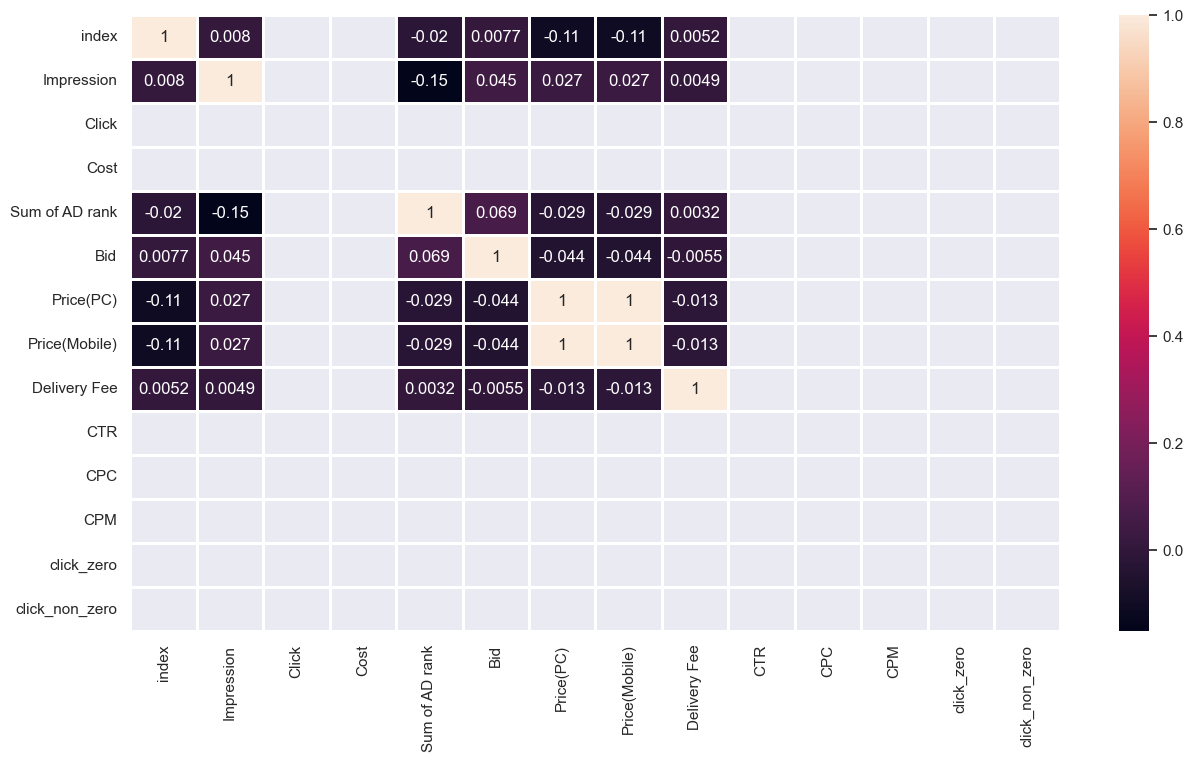

In [62]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
sns.heatmap(data = click_zero.corr(), annot=True, linewidths=1)

<AxesSubplot:>

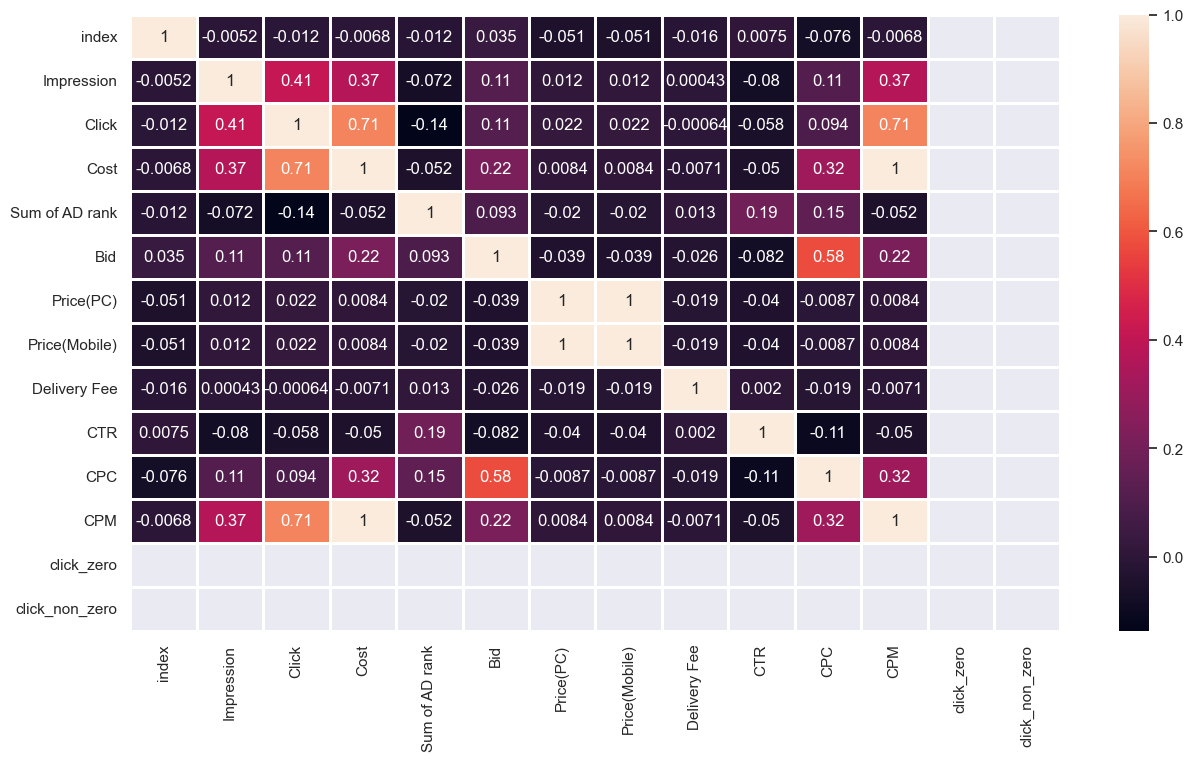

In [63]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
sns.heatmap(data = click_non_zero.corr(), annot=True, linewidths=1)

## Delivery Fee

In [64]:
deliverye_zero =  bidding_drop_null[bidding_drop_null['Delivery Fee'] <= 0 ]
deliverye_non_zero =  bidding_drop_null[bidding_drop_null['Delivery Fee'] > 0 ]

<AxesSubplot:>

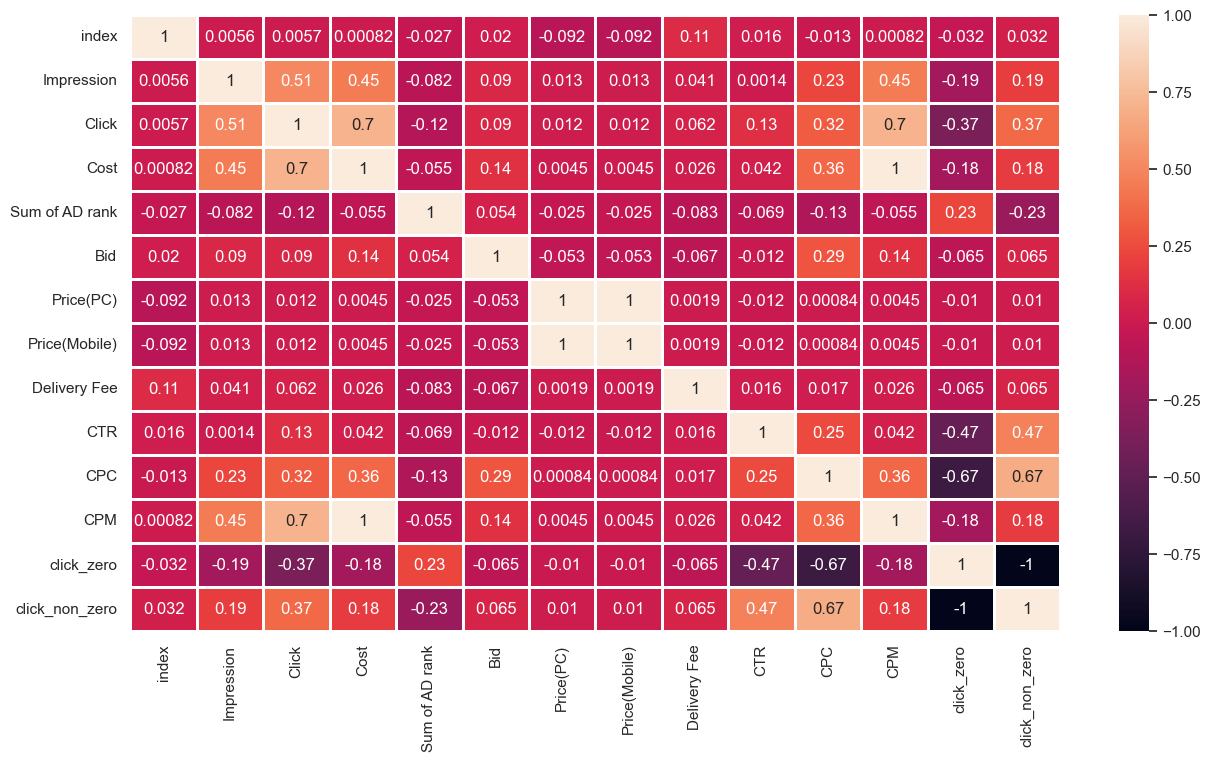

In [65]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
sns.heatmap(data = deliverye_zero.corr(), annot=True, linewidths=1)

<AxesSubplot:>

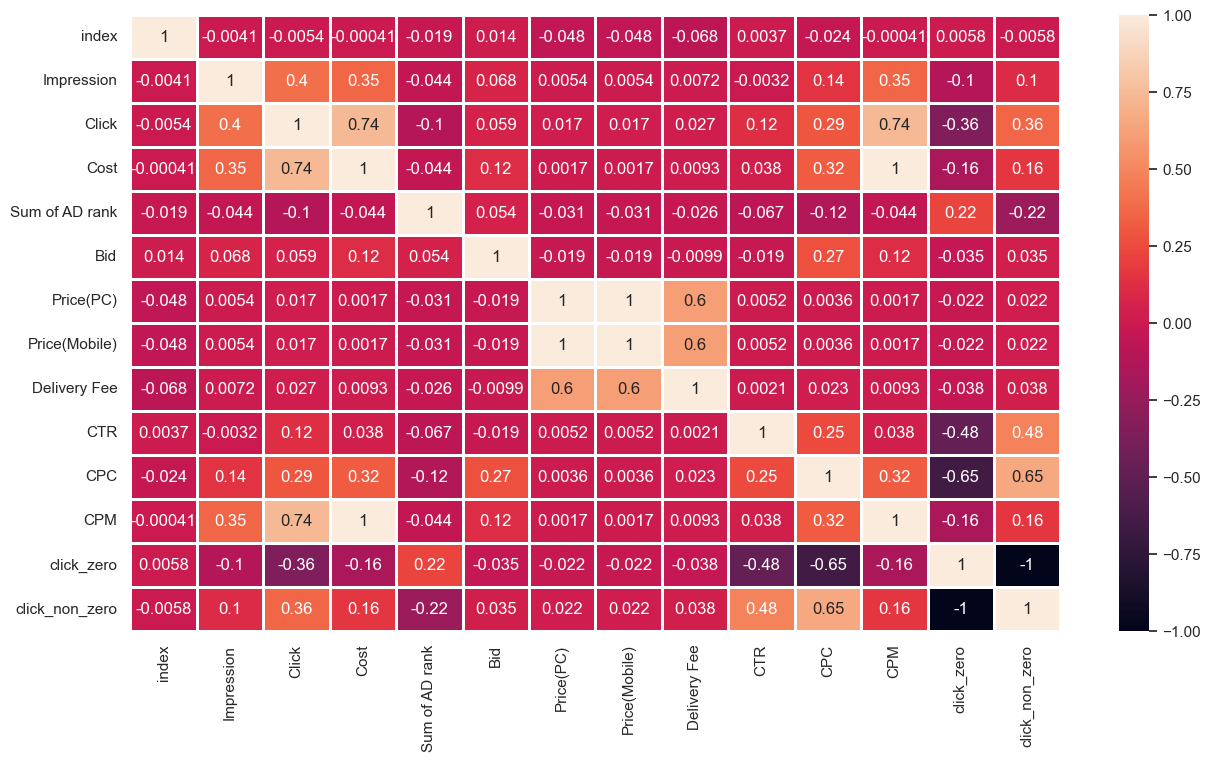

In [66]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
sns.heatmap(data = deliverye_non_zero.corr(), annot=True, linewidths=1)

## Price

In [67]:
price_mean_up = bidding_drop_null[bidding_drop_null['Price(PC)'] >= 182893]
price_mean_down = bidding_drop_null[bidding_drop_null['Price(PC)'] < 182893]

<AxesSubplot:>

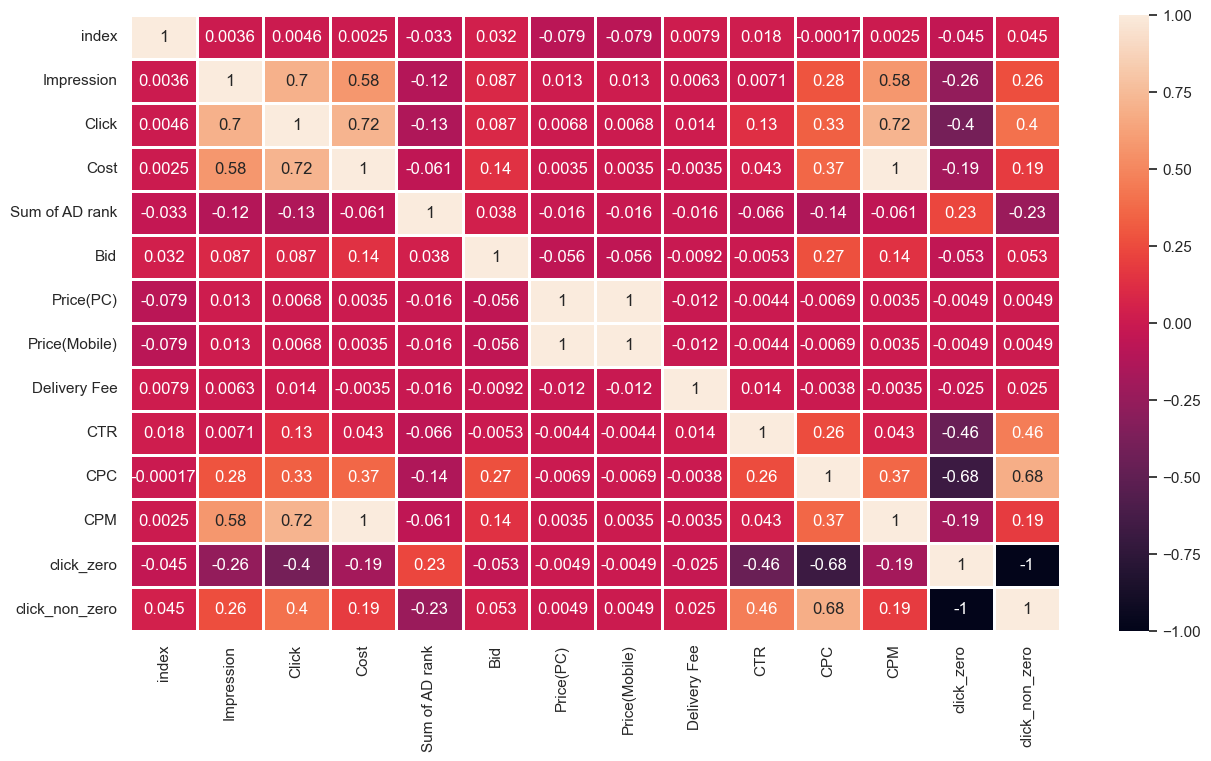

In [68]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
sns.heatmap(data = price_mean_up.corr(), annot=True, linewidths=1)

<AxesSubplot:>

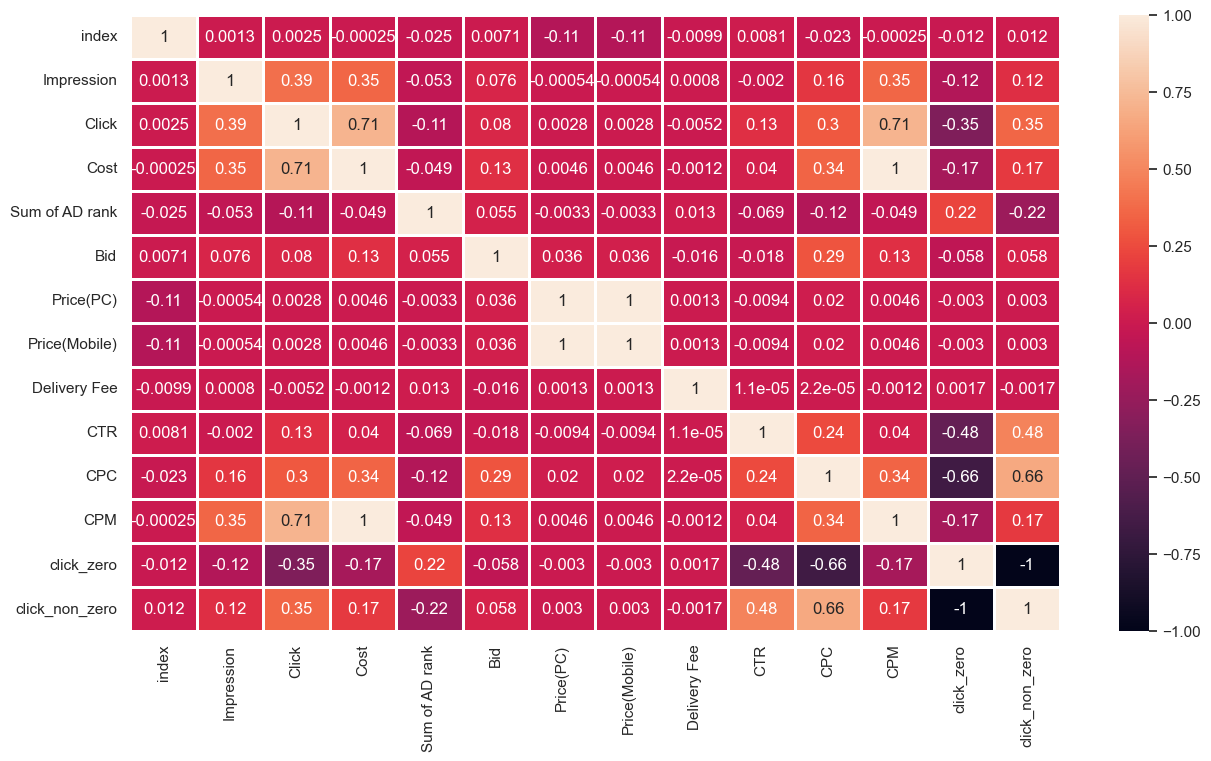

In [69]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
sns.heatmap(data = price_mean_down.corr(), annot=True, linewidths=1)

## Sum of AD rank

In [70]:
rank_mean_up =  bidding_drop_null[bidding_drop_null['Sum of AD rank'] <= 50 ]
rank_mean_down =  bidding_drop_null[bidding_drop_null['Sum of AD rank'] > 50 ]

<AxesSubplot:>

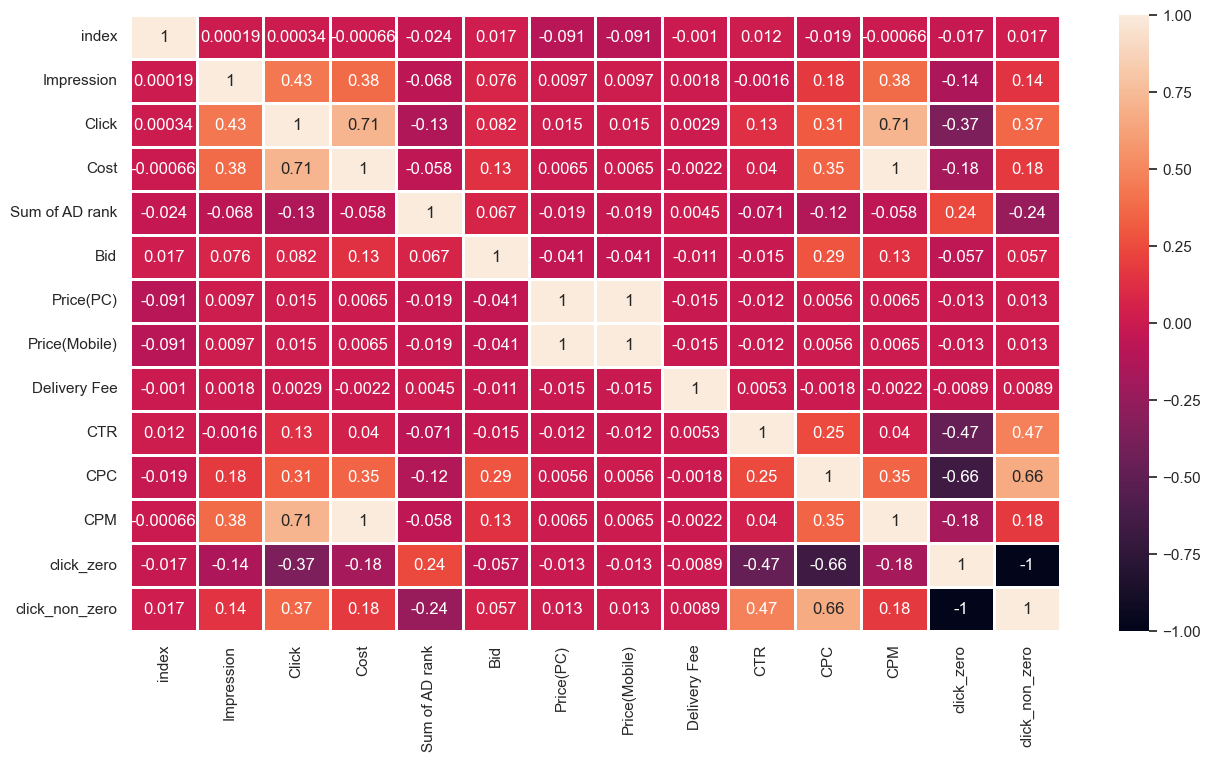

In [71]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
sns.heatmap(data = rank_mean_up.corr(), annot=True, linewidths=1)

<AxesSubplot:>

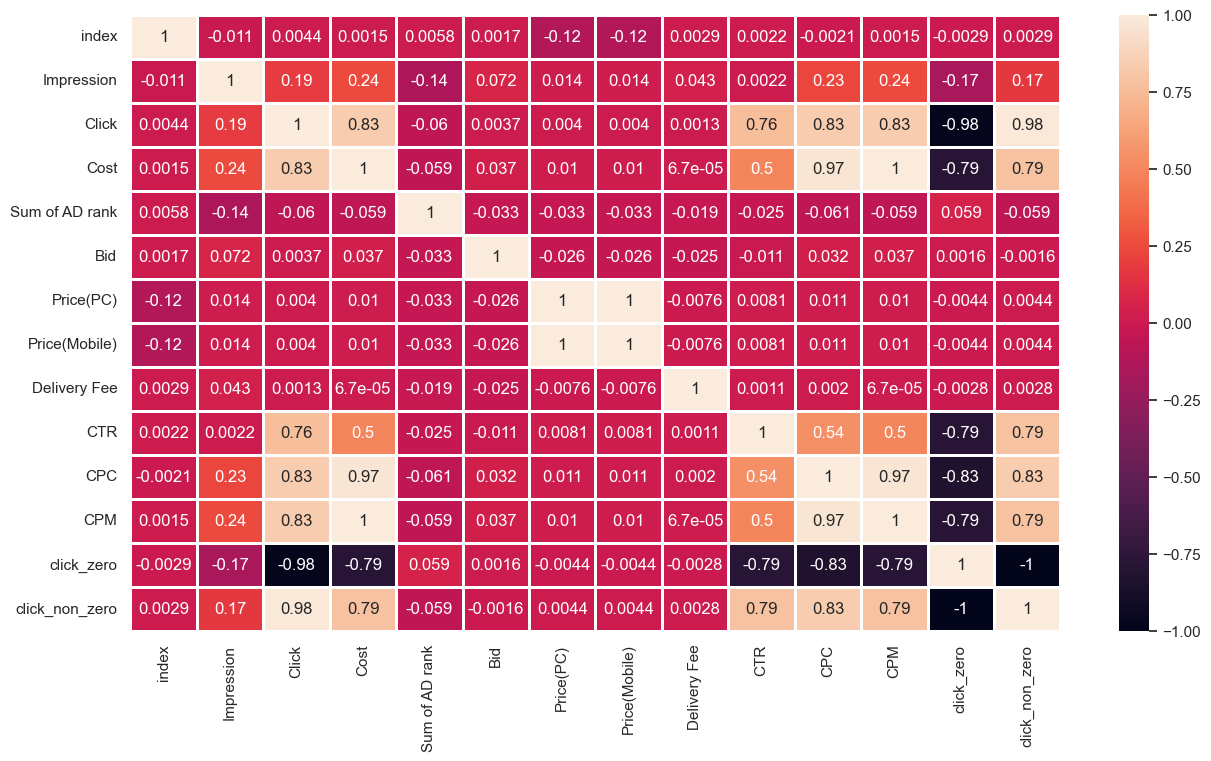

In [72]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
sns.heatmap(data = rank_mean_down.corr(), annot=True, linewidths=1)

## 시계열 분석

In [113]:
#결측치 처리

log_null_ts = log_df.copy()
drop_city = log_null_ts[log_null_ts['geoip_city_name'] != 'Seoul']
drop_city = drop_city[drop_city['geoip_city_name'] != 'Gyeonggi-do']

# drop_city.isnull().sum().sort_values(ascending=False)

log_drop_null = drop_city
log_drop_null['geoip_city_name'].fillna('un_city_name', inplace = True)
log_drop_null['category3'].fillna('un_category', inplace = True)
log_drop_null['uid'].fillna('un_name', inplace = True)
log_drop_null.dropna(axis = 0, inplace = True)
print(log_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

Unnamed: 0         0
uid                0
action_type        0
category1          0
category2          0
category3          0
collect_time       0
geoip_city_name    0
useragent_os       0
viewrate           0
viewtime           0
dtype: int64


In [114]:
log_data = log_df.copy()
log_data

,Unnamed: 0,uid,action_type,category1,category2,category3,collect_time,geoip_city_name,useragent_os,viewrate,viewtime
0,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,2022-12-29 17:29:02,Seongnam-si,Windows,100.0,80033
1,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,2022-12-29 12:56:38,Yongin-si,Windows,0.0,0
2,2,r8DXy2OtSl8AAojG,View,패브릭,커튼·부자재,암막커튼,2022-12-29 17:11:30,Seoul,iOS,100.0,947
3,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,2022-12-29 17:54:30,Gwangmyeong-si,Windows,0.0,0
4,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,2022-12-29 18:45:05,Jongno-gu,Mac OS X,100.0,1238
...,...,...,...,...,...,...,...,...,...,...,...
5659536,5659536,PUpxWWMWdcIACR2B,View,주방용품,칼·커팅기구,채칼·다지기·강판,2022-12-28 20:01:30,Seoul,Android,100.0,13893
5659537,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,2022-12-28 14:30:09,Jinju,Windows,0.0,0
5659538,5659538,diRXdmN49dUABrVo,View,가구,테이블·식탁·책상,식탁,2022-12-29 12:45:13,Gunpo,Android,100.0,47217
5659539,5659539,dusFzWJvp5cADhZW,View,가전·디지털,계절가전,전기히터·온풍기,2022-12-28 11:07:30,Seoul,Android,100.0,54030


In [102]:
bid_data = bidding_drop_null
bid_data

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM,click_zero,click_non_zero
date,,,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00,True,False
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00,True,False
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00,True,False
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,null_cat4,8.333333,50.0,0.15,False,True
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,null_cat4,0.000000,0.0,0.00,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00,True,False
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00,True,False
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,null_cat4,0.000000,0.0,0.00,True,False


In [100]:
# feature 수 확인
def descriptive_info(df):
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

# 결측치 확인
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

# 시간 데이터 datetime으로 바꾸기
# 시간 데이터에 컬럼은 직접 넣어줘야한다
def _trans_date_time(df, date):
    df.index = pd.to_datetime(df[date], infer_datetime_format=True)
    df.drop(date, axis=1, inplace=True)
    return df

# 시간 데이터 포멧 변경
# def _trans_date_time(df, date):
#     df.index = pd.to_datetime(df[date], format='%Y%m%d')
#     df.drop(date, axis=1, inplace=True)
#     return df


# model에 넣어줄 시간 데이터와 y데이터 변환
def prepare_data(df, ds, y):
 
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
   
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #
  print('The series is ready for use.\n')
  return df


# 시각화 함수
def _fig_plot(df, X, Y):

  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()
    
    


In [115]:
descriptive_info(log_data)

Features: 11   Entries: 5659541



Printing descriptive statistics...

          Unnamed: 0      viewrate      viewtime
count  5.659541e+06  5.657112e+06  5.659541e+06
mean   2.829770e+06  7.677686e+01  5.126022e+04
std    1.633769e+06  4.221447e+01  5.810345e+05
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.414885e+06  1.000000e+02  8.940000e+02
50%    2.829770e+06  1.000000e+02  1.010400e+04
75%    4.244655e+06  1.000000e+02  4.800500e+04
max    5.659540e+06  1.000000e+02  8.636989e+07


In [116]:
missing_val(log_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5659541 entries, 0 to 5659540
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   uid              object 
 2   action_type      object 
 3   category1        object 
 4   category2        object 
 5   category3        object 
 6   collect_time     object 
 7   geoip_city_name  object 
 8   useragent_os     object 
 9   viewrate         float64
 10  viewtime         int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 475.0+ MB
None


Features with missing values in descending order 


category3          0.137821
geoip_city_name    0.073687
uid                0.032920
viewrate           0.000429
Unnamed: 0         0.000000
action_type        0.000000
category1          0.000000
category2          0.000000
collect_time       0.000000
useragent_os       0.000000
viewtime           0.000000
dtype: float64


In [101]:
# 결측치 처리할때 datetime으로 변환했기 때문에 필요 없음
#밑에는 예시
# _trans_date_time(df = log_df, date = 'collect_time')

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime
collect_time,,,,,,,,,,
2022-12-29 17:29:02,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,Seongnam-si,Windows,100.0,80033
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0
2022-12-29 17:11:30,2,r8DXy2OtSl8AAojG,View,패브릭,커튼·부자재,암막커튼,Seoul,iOS,100.0,947
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0
2022-12-29 18:45:05,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,Jongno-gu,Mac OS X,100.0,1238
...,...,...,...,...,...,...,...,...,...,...
2022-12-28 20:01:30,5659536,PUpxWWMWdcIACR2B,View,주방용품,칼·커팅기구,채칼·다지기·강판,Seoul,Android,100.0,13893
2022-12-28 14:30:09,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,Jinju,Windows,0.0,0
2022-12-29 12:45:13,5659538,diRXdmN49dUABrVo,View,가구,테이블·식탁·책상,식탁,Gunpo,Android,100.0,47217


In [129]:
train = prepare_data(df = log_data, ds = 'collect_time', y = 'viewtime')
train

The series is ready for use.



,ds,y
0,2022-12-29 17:29:02,80033
1,2022-12-29 12:56:38,0
2,2022-12-29 17:11:30,947
3,2022-12-29 17:54:30,0
4,2022-12-29 18:45:05,1238
...,...,...
5659536,2022-12-28 20:01:30,13893
5659537,2022-12-28 14:30:09,0
5659538,2022-12-29 12:45:13,47217
5659539,2022-12-28 11:07:30,54030


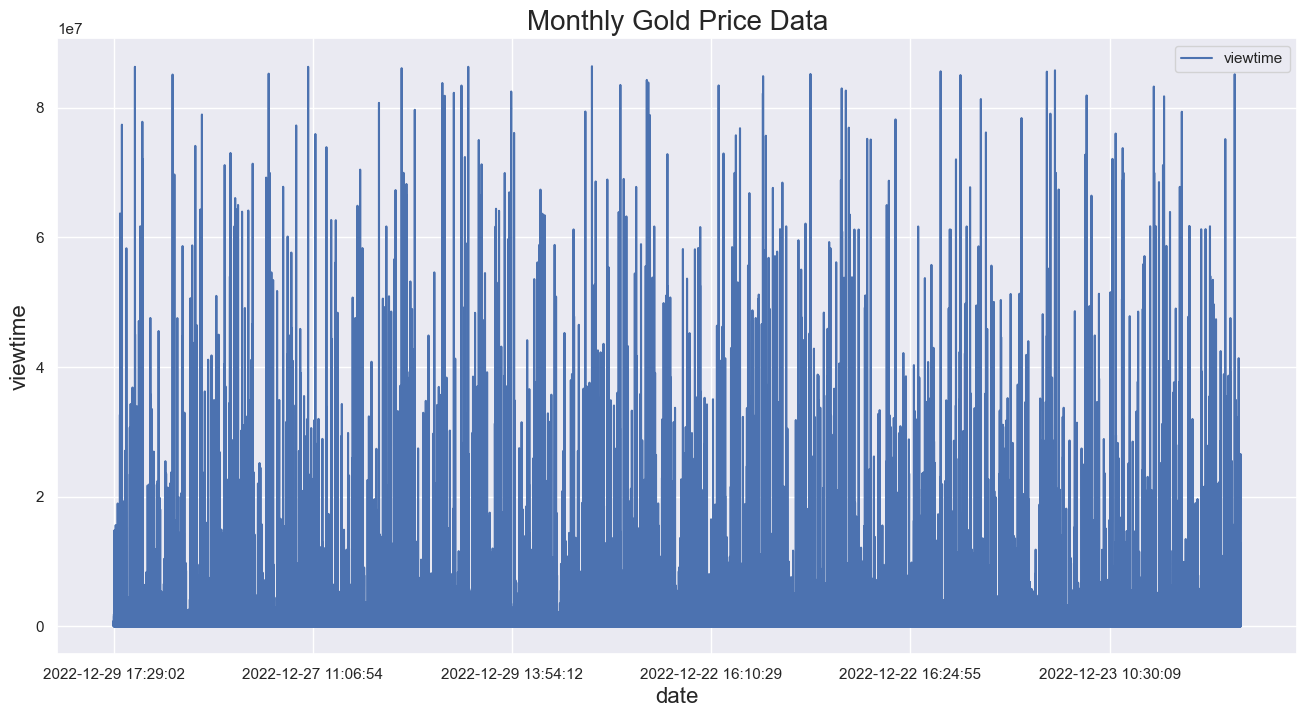

In [130]:
X = 'ds'
Y = 'y'
Label = "viewtime"
Figsize = (16,8)
Title = "Monthly Gold Price Data"
xAxisLabel = 'date'
yAxisLabel = 'viewtime'
_fig_plot(train, X, Y)

* growth='linear',
* changepoints=None,
* n_changepoints=25,
* changepoint_range=0.8,
* yearly_seasonality='auto',
* weekly_seasonality='auto',
* daily_seasonality='auto',
* holidays=None,
* seasonality_mode='additive',
* seasonality_prior_scale=10,
* holidays_prior_scale=10,
* changepoint_prior_scale=0.05,
* mcmc_samples=0,
* interval_width=0.8,
* uncertainty_samples=1000,
* stan_backend=None


In [ ]:
prophet = Prophet()
prophet.fit(train)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)